# 04 - CVAE for Travel Time Scenario Generation

Treina um **Conditional Variational Autoencoder (CVAE)** para gerar cenários de duração de viagem
condicionados em hora, dia da semana e variáveis de clima. Inclui:

- Split train/val/test
- Pré-processamento (one-hot + scaling)
- Treino com validação (early stopping)
- Busca simples de hiperparâmetros (vários tamanhos de modelo)
- Avaliação probabilística (MAE, cobertura de quantis, amostras geradas)


In [11]:
# Imports principais
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

print("torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch version: 2.9.1+cu128
Using device: cpu


In [12]:
# Configurações gerais

DATA_PATH = "data/processed/travel_features_rich.csv"

# Para não matar o PC, você pode limitar o número de amostras usadas
# (comente MAX_SAMPLES para usar tudo, se tiver GPU forte)
MAX_SAMPLES = 100_000  # ajuste conforme seu hardware

BATCH_SIZE = 512
EPOCHS = 50
PATIENCE = 5  # early stoppingfaça

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (1680498, 23)
   duration_min  hour  weekday  temp  feelslike   dew  humidity  precip  \
0      2.550000    17        2  11.3       11.3  -4.5     32.74     0.0   
1     13.734617    23        4   8.3        5.6  -2.1     47.62     0.0   
2     11.842950    19        2  10.5       10.5  -4.2     35.46     0.0   
3      4.060483    12        3   2.5       -1.5 -12.9     30.97     0.0   
4     23.020733    10        5   4.1        0.4  -8.7     38.64     0.0   

   precipprob preciptype  ...  windspeed  winddir  sealevelpressure  \
0         0.0       none  ...       11.1    264.0            1023.5   
1         0.0       none  ...       17.4    272.0            1017.3   
2         0.0       none  ...        8.9    291.0            1024.7   
3         0.0       none  ...       16.6    233.0            1021.3   
4         0.0       none  ...       17.3    318.0            1025.3   

   cloudcover  visibility  solarradiation  solarenergy  uvindex  \
0        19.2        16.0 

In [13]:
# ===== Pré-processamento =====

target_col = "duration_min"

numeric_weather = [
    "temp", "feelslike", "dew", "humidity", "precip", "precipprob",
    "snow", "snowdepth", "windgust", "windspeed", "winddir",
    "sealevelpressure", "cloudcover", "visibility", "solarradiation",
    "solarenergy", "uvindex"
]

context_basic = ["hour", "weekday"]
cat_cols = ["preciptype", "conditions", "icon"]

all_features = context_basic + numeric_weather + cat_cols

df_model = df[[target_col] + all_features].copy()

# Subamostrar se necessário
if MAX_SAMPLES is not None and len(df_model) > MAX_SAMPLES:
    df_model = df_model.sample(MAX_SAMPLES, random_state=42).reset_index(drop=True)
    print("Subsampled to:", df_model.shape)

# One-hot das categóricas
df_cat = pd.get_dummies(df_model[cat_cols], drop_first=True)
df_num = df_model[context_basic + numeric_weather]

X_full = pd.concat([df_num, df_cat], axis=1)
y_raw = df_model[target_col].values.astype(np.float32)

feature_names = X_full.columns.tolist()
print("Total input features:", len(feature_names))

# Transformação log no alvo
y_log = np.log1p(y_raw)

# Split train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_full.values, y_log, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15, random_state=42
)

print("Train size:", X_train.shape[0])
print("Val size:",   X_val.shape[0])
print("Test size:",  X_test.shape[0])

# Scaling
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_val_scaled   = x_scaler.transform(X_val)
X_test_scaled  = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled   = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

input_dim = X_train_scaled.shape[1]
print("Input dim:", input_dim)


Subsampled to: (100000, 23)
Total input features: 34
Train size: 72250
Val size: 12750
Test size: 15000
Total input features: 34
Train size: 72250
Val size: 12750
Test size: 15000
Input dim: 34
Input dim: 34


In [14]:
# ===== Dataset e DataLoaders =====

class TravelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = TravelDataset(X_train_scaled, y_train_scaled)
val_ds   = TravelDataset(X_val_scaled, y_val_scaled)
test_ds  = TravelDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)


(72250, 12750, 15000)

In [15]:
# ===== Definição do CVAE =====

class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=4):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        enc_input_dim = input_dim + 1  # x + y
        self.encoder = nn.Sequential(
            nn.Linear(enc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        dec_input_dim = input_dim + latent_dim
        self.decoder = nn.Sequential(
            nn.Linear(dec_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def encode(self, x, y):
        h = torch.cat([x, y], dim=1)
        h = self.encoder(h)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x, z):
        h = torch.cat([x, z], dim=1)
        y_hat = self.decoder(h)
        return y_hat

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        y_hat = self.decode(x, z)
        return y_hat, mu, logvar


def cvae_loss(y_true, y_pred, mu, logvar, beta=1.0):
    recon = nn.functional.mse_loss(y_pred, y_true, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon.detach(), kl.detach()


In [16]:
# ===== Funções de treino/val =====

def train_one_epoch(model, loader, optimizer, beta=1.0):
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for x_batch, y_batch in pbar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_hat, mu, logvar = model(x_batch, y_batch)
        loss, recon, kl = cvae_loss(y_batch, y_hat, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()

        bs = x_batch.size(0)
        total_loss += loss.item() * bs
        total_recon += recon.item() * bs
        total_kl += kl.item() * bs
        n += bs
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / n, total_recon / n, total_kl / n


def eval_one_epoch(model, loader, beta=1.0):
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n = 0

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_hat, mu, logvar = model(x_batch, y_batch)
            loss, recon, kl = cvae_loss(y_batch, y_hat, mu, logvar, beta=beta)

            bs = x_batch.size(0)
            total_loss += loss.item() * bs
            total_recon += recon.item() * bs
            total_kl += kl.item() * bs
            n += bs

    return total_loss / n, total_recon / n, total_kl / n

In [17]:
# ===== Busca simples de hiperparâmetros =====

configs = [
    {"hidden_dim": 32,  "latent_dim": 2, "beta": 0.1},
    {"hidden_dim": 64,  "latent_dim": 4, "beta": 0.1},
    {"hidden_dim": 64,  "latent_dim": 8, "beta": 0.5},
    {"hidden_dim": 128, "latent_dim": 8, "beta": 1.0},
]

results = []
best_state = None
best_val_loss = float("inf")
best_config = None

for cfg_idx, cfg in enumerate(tqdm(configs, desc="Testing configurations")):
    print("\n=== Config", cfg_idx, ":", cfg, "===")

    model = CVAE(input_dim=input_dim,
                 hidden_dim=cfg["hidden_dim"],
                 latent_dim=cfg["latent_dim"]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_cfg_val = float("inf")
    best_cfg_state = None
    patience_counter = 0

    epoch_pbar = tqdm(range(1, EPOCHS + 1), desc=f"Config {cfg_idx}", leave=True)
    for epoch in epoch_pbar:
        train_loss, train_recon, train_kl = train_one_epoch(
            model, train_loader, optimizer, beta=cfg["beta"]
        )
        val_loss, val_recon, val_kl = eval_one_epoch(
            model, val_loader, beta=cfg["beta"]
        )

        epoch_pbar.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'val_loss': f'{val_loss:.4f}'
        })

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:02d} | "
                  f"train_loss={train_loss:.4f} (recon={train_recon:.4f}, kl={train_kl:.4f}) | "
                  f"val_loss={val_loss:.4f} (recon={val_recon:.4f}, kl={val_kl:.4f})")

        if val_loss < best_cfg_val - 1e-4:
            best_cfg_val = val_loss
            best_cfg_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping for this config.")
                break

    results.append({"config": cfg, "best_val_loss": best_cfg_val})

    if best_cfg_val < best_val_loss:
        best_val_loss = best_cfg_val
        best_state = best_cfg_state
        best_config = cfg

print("\n=== Summary of configs ===")
for r in results:
    print(r)
print("\nBest config:", best_config, "with val_loss=", best_val_loss)

Testing configurations:   0%|          | 0/4 [00:00<?, ?it/s]


=== Config 0 : {'hidden_dim': 32, 'latent_dim': 2, 'beta': 0.1} ===


Config 0:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 01 | train_loss=0.6899 (recon=0.6380, kl=0.5195) | val_loss=0.2017 (recon=0.0833, kl=1.1836)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.1220 (recon=0.0295, kl=0.9251) | val_loss=0.1217 (recon=0.0318, kl=0.8992)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.1189 (recon=0.0272, kl=0.9163) | val_loss=0.1194 (recon=0.0268, kl=0.9260)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.1185 (recon=0.0269, kl=0.9165) | val_loss=0.1193 (recon=0.0277, kl=0.9161)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Early stopping for this config.

=== Config 1 : {'hidden_dim': 64, 'latent_dim': 4, 'beta': 0.1} ===


Config 1:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 01 | train_loss=0.5378 (recon=0.4857, kl=0.5209) | val_loss=0.1448 (recon=0.0522, kl=0.9263)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.0707 (recon=0.0158, kl=0.5494) | val_loss=0.0699 (recon=0.0153, kl=0.5459)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.0692 (recon=0.0146, kl=0.5467) | val_loss=0.0688 (recon=0.0139, kl=0.5489)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.0688 (recon=0.0142, kl=0.5460) | val_loss=0.0685 (recon=0.0145, kl=0.5397)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 20 | train_loss=0.0683 (recon=0.0137, kl=0.5457) | val_loss=0.0684 (recon=0.0137, kl=0.5469)
Early stopping for this config.

=== Config 2 : {'hidden_dim': 64, 'latent_dim': 8, 'beta': 0.5} ===


Config 2:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 01 | train_loss=0.5102 (recon=0.4082, kl=0.2039) | val_loss=0.2550 (recon=0.1066, kl=0.2967)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.1434 (recon=0.0354, kl=0.2160) | val_loss=0.1434 (recon=0.0380, kl=0.2108)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.1418 (recon=0.0343, kl=0.2150) | val_loss=0.1407 (recon=0.0343, kl=0.2127)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.1409 (recon=0.0334, kl=0.2150) | val_loss=0.1425 (recon=0.0350, kl=0.2149)
Early stopping for this config.

=== Config 3 : {'hidden_dim': 128, 'latent_dim': 8, 'beta': 1.0} ===


Config 3:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 01 | train_loss=0.5217 (recon=0.3811, kl=0.1406) | val_loss=0.2507 (recon=0.0759, kl=0.1749)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.2393 (recon=0.0681, kl=0.1712) | val_loss=0.2389 (recon=0.0644, kl=0.1745)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.2381 (recon=0.0668, kl=0.1713) | val_loss=0.2383 (recon=0.0682, kl=0.1701)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.2373 (recon=0.0663, kl=0.1710) | val_loss=0.2381 (recon=0.0642, kl=0.1739)


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Early stopping for this config.

=== Summary of configs ===
{'config': {'hidden_dim': 32, 'latent_dim': 2, 'beta': 0.1}, 'best_val_loss': 0.1184011991444756}
{'config': {'hidden_dim': 64, 'latent_dim': 4, 'beta': 0.1}, 'best_val_loss': 0.0684770826159739}
{'config': {'hidden_dim': 64, 'latent_dim': 8, 'beta': 0.5}, 'best_val_loss': 0.14068357759597255}
{'config': {'hidden_dim': 128, 'latent_dim': 8, 'beta': 1.0}, 'best_val_loss': 0.2375798875397327}

Best config: {'hidden_dim': 64, 'latent_dim': 4, 'beta': 0.1} with val_loss= 0.0684770826159739


In [ ]:
# ===== Carregar melhor modelo e avaliar no teste =====

best_model = CVAE(input_dim=input_dim,
                  hidden_dim=best_config["hidden_dim"],
                  latent_dim=best_config["latent_dim"]).to(device)
best_model.load_state_dict(best_state)

test_loss, test_recon, test_kl = eval_one_epoch(
    best_model, test_loader, beta=best_config["beta"]
)
print(f"Test loss={test_loss:.4f} (recon={test_recon:.4f}, kl={test_kl:.4f})")

best_model.eval()

def generate_samples(model, X_scaled, n_samples=50, batch_size=1024):
    model.eval()
    N = X_scaled.shape[0]
    all_samples = []

    with torch.no_grad():
        pbar = tqdm(range(0, N, batch_size), desc="Generating samples")
        for start in pbar:
            end = min(start + batch_size, N)
            x_batch = torch.tensor(X_scaled[start:end], dtype=torch.float32, device=device)

            bs = x_batch.size(0)
            x_rep = x_batch.unsqueeze(1).repeat(1, n_samples, 1)
            x_rep = x_rep.view(bs * n_samples, -1)

            z = torch.randn(bs * n_samples, best_model.latent_dim, device=device)

            h = torch.cat([x_rep, z], dim=1)
            y_hat = best_model.decoder(h)
            y_hat = y_hat.view(bs, n_samples)

            all_samples.append(y_hat.cpu().numpy())
            
            pbar.set_postfix({'batch': f'{start//batch_size + 1}/{(N-1)//batch_size + 1}'})

    return np.vstack(all_samples)


N_TEST_SAMPLES = 500
print("Generating", N_TEST_SAMPLES, "samples per test point...")
y_samples_test_scaled = generate_samples(best_model, X_test_scaled, n_samples=N_TEST_SAMPLES)
print("y_samples_test_scaled shape:", y_samples_test_scaled.shape)

# Converter de volta para minutos
y_samples_test_log = y_scaler.inverse_transform(y_samples_test_scaled)
y_samples_test = np.expm1(y_samples_test_log)

y_test_minutes = np.expm1(y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))).flatten()

Test loss=0.0686 (recon=0.0138, kl=0.5482)
Generating 50 samples per test point...


Generating samples:   0%|          | 0/15 [00:00<?, ?it/s]

y_samples_test_scaled shape: (15000, 50)


In [19]:
# ===== Métricas probabilísticas =====

y_mean_cvae = y_samples_test.mean(axis=1)

mae_cvae  = mean_absolute_error(y_test_minutes, y_mean_cvae)
rmse_cvae = math.sqrt(mean_squared_error(y_test_minutes, y_mean_cvae))

print(f"[CVAE] Test MAE (mean of samples):  {mae_cvae:.3f}")
print(f"[CVAE] Test RMSE (mean of samples): {rmse_cvae:.3f}")

q10_cvae = np.percentile(y_samples_test, 10, axis=1)
q50_cvae = np.percentile(y_samples_test, 50, axis=1)
q90_cvae = np.percentile(y_samples_test, 90, axis=1)

coverage_10_90 = ((y_test_minutes >= q10_cvae) & (y_test_minutes <= q90_cvae)).mean()
print(f"[CVAE] 10-90% interval coverage: {coverage_10_90*100:.1f}%")


[CVAE] Test MAE (mean of samples):  6.460
[CVAE] Test RMSE (mean of samples): 8.953
[CVAE] 10-90% interval coverage: 74.4%


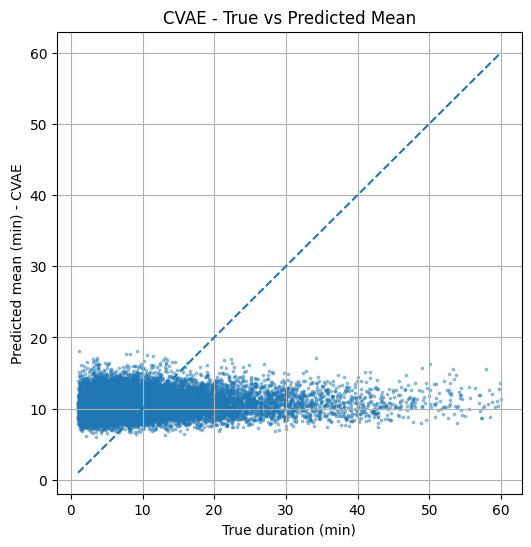


Example idx= 404 True duration= 16.15 min
Sample stats: mean= 9.88  q10= 2.71  q50= 7.75  q90= 19.04


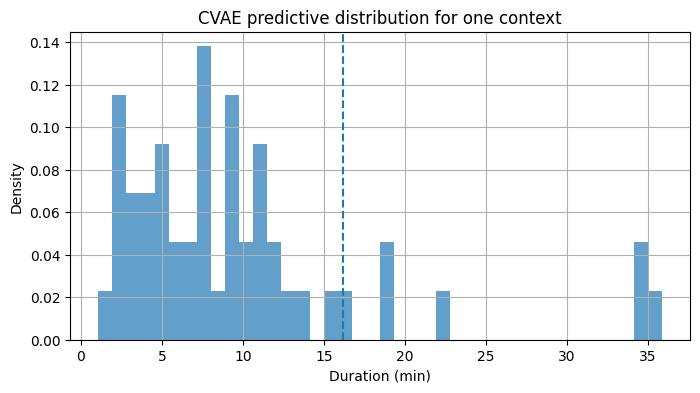


Example idx= 5221 True duration= 3.72 min
Sample stats: mean= 11.07  q10= 4.8  q50= 9.79  q90= 21.26


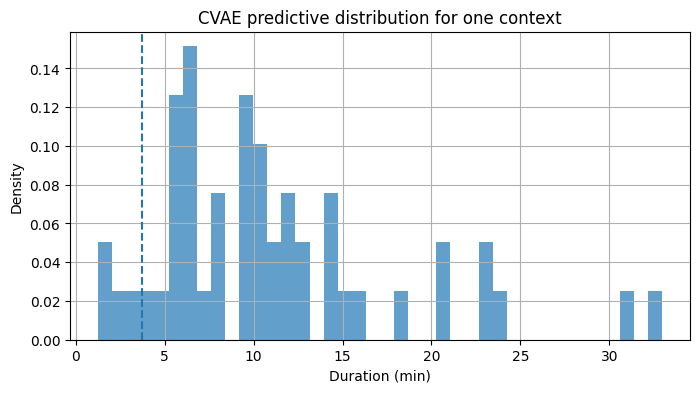


Example idx= 3357 True duration= 14.59 min
Sample stats: mean= 8.44  q10= 3.22  q50= 6.62  q90= 14.95


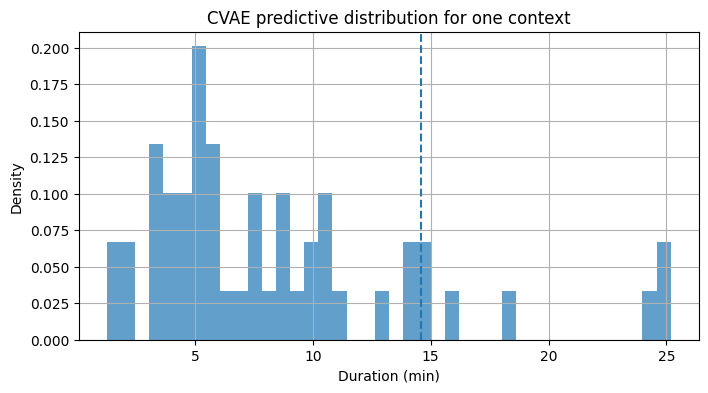

In [20]:
# ===== Visualizações =====

plt.figure(figsize=(6,6))
plt.scatter(y_test_minutes, y_mean_cvae, s=3, alpha=0.4)
min_v = min(y_test_minutes.min(), y_mean_cvae.min())
max_v = max(y_test_minutes.max(), y_mean_cvae.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.xlabel("True duration (min)")
plt.ylabel("Predicted mean (min) - CVAE")
plt.title("CVAE - True vs Predicted Mean")
plt.grid(True)
plt.show()

# Distribuições previstas para alguns exemplos
np.random.seed(7)
example_indices = np.random.choice(len(y_test_minutes), size=3, replace=False)

for idx in example_indices:
    true_y = y_test_minutes[idx]
    samples = y_samples_test[idx]

    print("\nExample idx=", idx, "True duration=", round(true_y, 2), "min")
    print("Sample stats: mean=", round(samples.mean(), 2),
          " q10=", round(np.percentile(samples,10),2),
          " q50=", round(np.percentile(samples,50),2),
          " q90=", round(np.percentile(samples,90),2))

    plt.figure(figsize=(8,4))
    plt.hist(samples, bins=40, density=True, alpha=0.7)
    plt.axvline(true_y, linestyle="--")
    plt.xlabel("Duration (min)")
    plt.ylabel("Density")
    plt.title("CVAE predictive distribution for one context")
    plt.grid(True)
    plt.show()
